<a href="https://colab.research.google.com/github/shank10/CV/blob/master/skewed_data_breast_cancer_mortality_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# load and summarize the dataset
from pandas import read_csv
# define the dataset location
filename ='/content/haberman.csv'
# define the dataset column names
columns = ['age','year','nodes','class']
# load the csv file as a data frame
dataframe = read_csv(filename, header=None, names=columns)
# summarize each column
report = dataframe.describe()
print(dataframe.head())
#All values are int. We should look at it visually too.
print(report)
#All operations were performed between 1958 to 1969

   age  year  nodes  class
0   30    64      1      1
1   30    62      3      1
2   30    65      0      1
3   31    59      2      1
4   31    65      4      1
              age        year       nodes       class
count  306.000000  306.000000  306.000000  306.000000
mean    52.457516   62.852941    4.026144    1.264706
std     10.803452    3.249405    7.189654    0.441899
min     30.000000   58.000000    0.000000    1.000000
25%     44.000000   60.000000    0.000000    1.000000
50%     52.000000   63.000000    1.000000    1.000000
75%     60.750000   65.750000    4.000000    2.000000
max     83.000000   69.000000   52.000000    2.000000


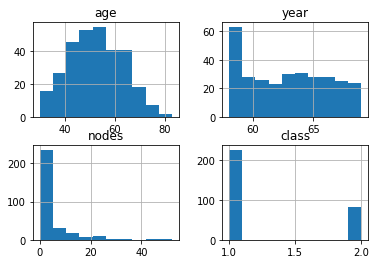

In [9]:
from matplotlib import pyplot
%matplotlib inline
dataframe['class'].value_counts()
dataframe.hist()
pyplot.show()
#So class 2 is about 25% of the overall population
#What the heck, lets get the exact percentage

In [12]:
from collections import Counter
# summarize the class distribution
target = dataframe['class'].values
counter = Counter(target)
for k,v in counter.items():
  per = v / len(target) * 100
  print('Class=%d, Count=%d, Percentage=%.3f%%'% (k, v, per))

Class=1, Count=225, Percentage=73.529%
Class=2, Count=81, Percentage=26.471%


WE have the baseline numbers. Lets test multiple ML models for fitment

(306, 3) (306,) Counter({0: 225, 1: 81})
Mean BSS: -0.000 (0.000)
>LR 0.060 (0.143)
>LDA 0.064 (0.154)
>QDA 0.027 (0.221)
>GNB 0.012 (0.212)
>MNB -0.211 (0.369)
>GPC -0.142 (0.041)


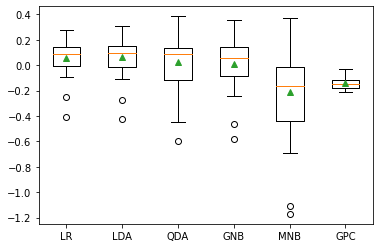

In [23]:
# So the skew exists. And this should prompt us to evaluate various algos
# Lets evaluate candidate models using repeated stratifiedk-fold cross-validation
# We will use K=10, which means each training set will contain 306/10 or 30 samples. 
# Also we should maintain the same distribution of the two classes in each batch 74:26
# baseline model and test harness for the haberman datasetfrom collections import Counter
from numpy import mean, std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier
# load the dataset
def load_dataset(full_path):
# load the dataset as a numpy array
  data = read_csv(full_path, header=None)
  # retrieve numpy array
  data = data.values
  # split into input and output elements
  X, y = data[:, :-1], data[:, -1]
  # label encode the target variable to have the classes 0 and 1
  y = LabelEncoder().fit_transform(y)
  return X, y
# calculate brier skill score (BSS)
def brier_skill_score(y_true, y_prob):
  # calculate reference brier score
  ref_probs = [0.26471 for _ in range(len(y_true))]
  bs_ref = brier_score_loss(y_true, ref_probs)
  # calculate model brier score
  bs_model = brier_score_loss(y_true, y_prob)
  # calculate skill score
  return 1.0 - (bs_model / bs_ref)
# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # define the model evaluation metric
  metric = make_scorer(brier_skill_score, needs_proba=True)
  # evaluate models
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

# define models to test
def get_models():
  models, names = list(), list()
  # LR
  models.append(LogisticRegression(solver='lbfgs'))
  names.append('LR')
  # LDA
  models.append(LinearDiscriminantAnalysis())
  names.append('LDA')
  # QDA
  models.append(QuadraticDiscriminantAnalysis())
  names.append('QDA')
  # GNB
  models.append(GaussianNB())
  names.append('GNB')
  # MNB
  models.append(MultinomialNB())
  names.append('MNB')
  # GPC
  models.append(GaussianProcessClassifier())
  names.append('GPC')
  return models, names

# define the location of the dataset
full_path ='/content/haberman.csv'
# load the dataset
X, y = load_dataset(full_path)
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
basemodel = DummyClassifier(strategy='prior')
# evaluate the model
basescores = evaluate_model(X, y, basemodel)
print('Mean BSS: %.3f (%.3f)'% (mean(basescores), std(basescores)))

# Call Real models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
  # evaluate the model and store 
  resultsscores = evaluate_model(X, y, models[i])
  results.append(resultsscores)
  # summarize and store
  print('>%s %.3f (%.3f)'% (names[i], mean(resultsscores), std(resultsscores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

it can be a good practice to scale data for some algorithms if the variables have different units of measure,  as they do in this case.  Algorithms like the LR and LDA are sensitive to thedistribution of the data and assume a Gaussian distribution for the input variables, which we don’t have

>LR 0.062 (0.140)
>LDA 0.064 (0.154)
>QDA 0.027 (0.221)
>GNB 0.012 (0.212)
>GPC 0.097 (0.133)


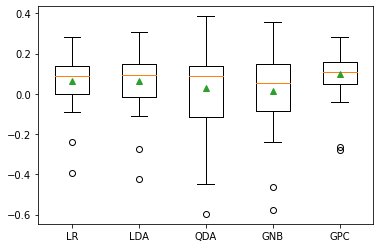

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# define models to test.
# Removed MNB as it cannot handle negative values. 
def get_models():
  models, names = list(), list()
  # LR
  models.append(LogisticRegression(solver='lbfgs'))
  names.append('LR')
  # LDA
  models.append(LinearDiscriminantAnalysis())
  names.append('LDA')
  # QDA
  models.append(QuadraticDiscriminantAnalysis())
  names.append('QDA')
  # GNB
  models.append(GaussianNB())
  names.append('GNB')
  # GPC
  models.append(GaussianProcessClassifier())
  names.append('GPC')
  return models, names

# Call Real models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
  # evaluate the model and store 
  # create a pipeline
  pipeline = Pipeline(steps=[('t', StandardScaler()),('m',models[i])])
  resultsscores = evaluate_model(X, y, pipeline)
  results.append(resultsscores)
  # summarize and store
  print('>%s %.3f (%.3f)'% (names[i], mean(resultsscores), std(resultsscores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

So Standardization, didn't impact either Logistics or Linear Discriminant but it made GPC the best performing algo.

However, there is one other transformation that we can do - to make the data more gaussian. Lets use powertransform to do that. Power transform  makes use of a log()function,  which does not work on zero values.  We have zero values in our dataset, therefore we will scale the dataset prior to the powertransform using a MinMaxScaler.

>LR 0.110 (0.142)
>LDA 0.107 (0.164)
>QDA 0.107 (0.199)
>GNB 0.097 (0.172)
>GPC 0.100 (0.130)


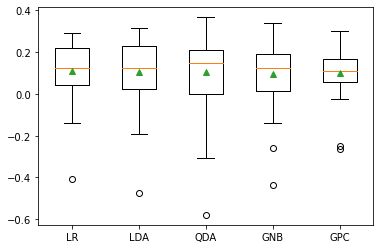

In [26]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
# Call Real models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
  # evaluate the model and store 
  # create a pipeline
  steps = [('t1', MinMaxScaler()), ('t2', PowerTransformer()),('m',models[i])]
  pipeline = Pipeline(steps=steps)
  resultsscores = evaluate_model(X, y, pipeline)
  results.append(resultsscores)
  # summarize and store
  print('>%s %.3f (%.3f)'% (names[i], mean(resultsscores), std(resultsscores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

So as expected, gaussian transform improved LR, LDA and QDA. Now the best restults are coming from LR. The overall accuracy is not very high. But this is the best that we can get from the limited dataset. So lets fit a LR model on the entire dataset and to test it we will pass the model 3 survived cases and 3 did not survive cases and evaluate its probabilistic prediction.

In [27]:
finalsteps = [('t1', MinMaxScaler()), ('t2', PowerTransformer()),('m',LogisticRegression(solver='lbfgs'))]
model = Pipeline(steps=finalsteps)
model.fit(X, y)
# some survival cases
print('Survival Cases:')
data = [[31,59,2], [31,65,4], [34,60,1]]
for row in data:
  # make prediction
  yhat = model.predict_proba([row])
  # get percentage of survival
  p_survive = yhat[0, 0] * 100
  # summarize
  print('>data=%s, Survival=%.3f%%'% (row, p_survive))
# some non-survival cases
print('Non-Survival Cases:')
data = [[44,64,6], [34,66,9], [38,69,21]]
for row in data:
  # make prediction
  yhat = model.predict_proba([row])
  # get percentage of survival
  p_survive = yhat[0, 0] * 100
  # summarize
  print('>data=%s, Survival=%.3f%%'% (row, p_survive))

Survival Cases:
>data=[31, 59, 2], Survival=83.597%
>data=[31, 65, 4], Survival=77.264%
>data=[34, 60, 1], Survival=86.776%
Non-Survival Cases:
>data=[44, 64, 6], Survival=63.092%
>data=[34, 66, 9], Survival=63.452%
>data=[38, 69, 21], Survival=53.389%


On conclusion, we have a model which works relatively alright for non-survival cases too. With added real data, its accuracy will improve. Anyway the objective of this exercise was to look at how data transformation impacts the models performance; which is clearly visible.